In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
# Hyper Parameters
EPOCH = 1               # 训练次数
BATCH_SIZE = 50
LR = 0.001            # 学习率
DOWNLOAD_MNIST = False   # s如果已经下载过了则修改为false


In [4]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,    #如果要下载的是训练集，则置为true，如果要测试集则置为false
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist/
    Split: Train
    StandardTransform
Transform: ToTensor()


torch.Size([60000, 28, 28])
torch.Size([60000])


D:\anaconda1\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\anaconda1\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


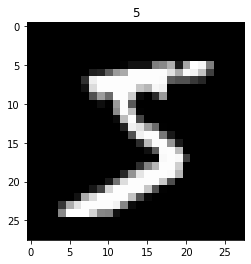

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [5]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()
print(train_data.train_data[0])

In [6]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.data, dim=1)).type(torch.FloatTensor)[:2000]/255.  
# shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.targets[:2000]

print(test_y)

tensor([7, 2, 1,  ..., 3, 9, 5])


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)conv1是卷积网络的第一层
            nn.Conv2d(                      #包括conv2d卷积层，激励函数，池化层
                in_channels=1,              # 因为输入的只有一个通道
                out_channels=16,            # 希望输出16个通道（也就是由16个权重核）（也就是输出16张特表
                kernel_size=5,              # 权重核的大小（5*5）
                stride=1,                   # 步长1
                padding=2,                  
                #  padding=(kernel_size-1)/2 if stride=1
                #向左向右向上向下扩张2，为了保持输入size和输出size相同
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # 激励函数
            nn.MaxPool2d(kernel_size=2),    # 池化层(16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        #最后得到了32个7*7的表，一共32*7*7个特征输入
        self.fc = nn.Sequential(
            nn.Linear(32*7*7,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10)
        )
        #最后得到了
        # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)      #每次输入了BATCH_SIZE张图片，每张图片有32*7*7
        #也就是[BATCH_SIZE,32,7,7]
        x = x.view(x.size(0), -1)    #将每张图片的32*7*7flatter，变成一维的数组
        #整体是二位的，因为有BATCH_SIZE个数组   >[BATCH_SIZE,32*7*7]
        output = self.fc(x)
        return output, x    # return x for visualization
    
#conv2d是一个卷积
#

In [9]:
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [14]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   

loss_func = nn.CrossEntropyLoss()                          

In [ ]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()   #因为softmax是个单调递增的，所以就不需要再套一个了，直接取最大值
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

In [38]:
5/255

0.0196078431372549

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]]])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
import numpy as np
from torchvision import transforms

data = np.random.randint(0, 255, size=6)
img = data.reshape(2,1,3)
print(img)
img_tensor = transforms.ToTensor()(img) # 转换成tensor
print(img_tensor)

[[[180 107  32]]

 [[133  79  42]]]
tensor([[[180],
         [133]],

        [[107],
         [ 79]],

        [[ 32],
         [ 42]]], dtype=torch.int32)
